# Foreword

**Background** This tutorial assumes that you are familiar with Pytorch. If you have not used Pytorch before I would recommend first going through the [basic tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html). Otherwise the tutorial only assumes undergraduate level understanding of machine learning and statistics. 

# Representation of Predictions

Before we start to work with any predictions we must first think about how to represent our prediction. For example, when predicting tomorrow's temperature, we might want to represent it as a single number (point prediction), such as 80F, or we might want to represent it as a cumulative density function (CDF). 

Each representation has its pros and cons. Depending on the different requirements during training/deployment, we might even want to convert between different representations. For example, we might initially start from an ensemble prediction (maybe because we trained multiple models), then convert it into a cumulative density function prediction or a point prediction (which are more interpretable and easier to work with). Conversion is one of the main features of torchuq, and we will come back to this topic in a later tutorial. 

This notebook aims to introduce some of the popular representations, and metrics to measure the quality of the prediction. Torchuq currently supports most popular representations and metrics. We will first discuss the regression setup (where the predicted quantity is a real number) and then discuss the classification setup (where the predicted quantity can take a finite number of values). 

# Part I: Regression

We first list the types of predictions currently supported by torchuq for regression. You can skip this part and come back later as a reference. 

| Name          | Variable type/shape  |  Special requirement | 
| -----------   | --------------       |   --------- | 
| Point         | ``array [batch_size] with float32/64 dtype`` |                       
| Distribution  | Python class that behaves like ``torch.distributions.Distribution`` |
| Interval      | ``array [batch_size, 2]``   | 
| Quantile      | ``array [batch_size, num_quantile, 2]`` or ``[batch_size, num_quantile]``  |
| Particle      | ``array [batch_size, num_particle]``    |
| Ensemble      | ``dict: name -> prediction`` | name must start with prediction type and a string (with no special characters), such as 'point_1' | 



## Running example 

As a running example we will predict the housing prices. For convenience, we have pretrained a set of predictions. In the following chapters we will see how to use torchuq to learn these predictions from data (hint: it only takes a few lines of code). But for now let's just load them to learn how they are represented and how to visualize them. 

In [1]:
# We first must important the dependencies, and make sure that the torchuq package is in PYTHONPATH
# If you are running this notebook in the original directory as in the repo, then the following statement should work
import sys
sys.path.append('../..')   # Include the directory that contains the torchuq package
import torch  

reader = torch.load('pretrained/boston_pretrained.tar')  # Load the pretrained predictions
labels = reader['labels']   # Load the true label (i.e. the ground truth housing prices)

## 1. Point Predictions

Point prediction is the simplest type of prediction, where we use a single number to represent the prediction. Point predictions are widespread because of their simplicity --- a single number is easy to communicate and interpret. However, point predictions do not represent the uncertainty in the prediction. 

A point prediction is represented by an torch array of shape `[batch_size]`. Note that following pytorch conventions, batching is mandatory in torchuq. For example, even when ``batch_size=1`` a point prediction must be represented as an array of shape `[1]` instead of a single number. Here we load the pretrained point prediction for the Boston housing dataset and print its shape. 

In [2]:
predictions_point = reader['predictions_point']
print(predictions_point.shape)

torch.Size([101])


### Metrics and Visualizations for Point Predictions

There are many ways to visualize or measure the quality of a point prediction. Here we explain several common ones. For other visualizations and metrics please refer to [TBD] 

**Scatter plot** visualizes the relationship between the prediction and the label. On the x-axis we plot the predicted value, and on the y-axis we plot the true label. If the prediction is perfect, then all points should lie on the diagonal line (i.e. predicted value = true label). In torchuq this is accomlished by the `plot_scatter` function. 

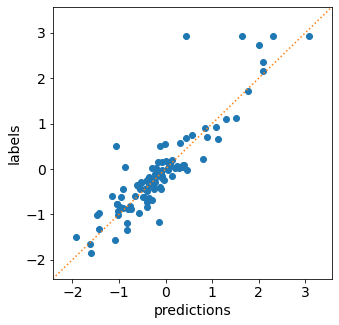

In [3]:
from torchuq.metric import point    # All point prediction metrics and visualizations are included in the torchuq.metric.point sub-package. 
point.plot_scatter(predictions_point, labels)

**Scoring Rules** The classic way to evaluate a point prediction is to compute scoring rules [1]. 

<details>
    <summary><b>[Click to expand]</b> A Detour into the Theory of Scoring Rules</summary>
    
    <h5> Evaluating Point Forecasts with Scoring Functions </h5>
    
    <p> Suppose we make a prediction $x$ and observe true label $y$, a scoring function $s$ is a map $s: x, y \mapsto s(x, y)$ that measures how good or bad a prediction is. An example scoring rule is the L2 score: $s_{\mathrm{L2}}(x, y) = (x - y)^2$. Intuitively, a high score indicates a poor prediction, and a low score indicates a good prediction. However, the exact meaning of good vs. poor prediction is ambiguous. The key issue is that a point prediction is never "perfect" if there is any uncertainty. If we predict $x$ while the true label is distributed according to the random variable $Y$, then we can never have $x = Y$ almost surely (unless there is no uncertainty so $Y$ is a deterministic random variable). For example, the median and the mean of $Y$ might be different, one practitioner might want to predict the median, and another practitioner might want to predict the mean. The two goals are inherently conflictory. </p>
    
    <p> To resolve the ambiguity we can specify the prediction target [1]. For example, we can aim to predict the mean, and design a scoring function that is small (i.e. indicates a good prediction) if the prediction $x$ is "close" to the mean $\mathbb{E}[Y]$. More generally, let $d_Y$ denote the probability law of the random variable $Y$, we specify some functional $F: d_Y \mapsto \mathbb{R}$ and aim to predict $F(d_Y)$. In the previous example, $F$ is the mean functional $F(d_Y) = \mathbb{E}(Y)$. We say that a scoring rule $s$ elicits $F$ if the score is small whenever $x \approx F(d_Y)$ and large whenever $x \not\approx F(d_Y)$. Formally  </p>
</details>

<br> 
In torchuq common scoring rules are implemented with the ``compute_scores`` function. This function returns a dictionary with many common scores. To access individual scoring rules please refer to [TBD]

## 2. Distribution Predictions

A distribution prediction is a cumulative distribution function (CDF) over the label, i.e. it is a function $F: \mathbb{R} \to [0, 1]$ that is monotonic and upward continuous. Distribution prediction is very informative. For example, if we want to predict tomorrow's temperature, then a CDF prediction would specify the (predicted) probability of each possible temperature value. Ideally distribution predictions should predict the true probability: $ F(c) = \mathrm{Pr}[Y \leq c], \forall c$ though this is usually very difficult [2]. 

Torchuq inherits the torch interface for representing a distribution, i.e. a distribution prediction is represented by any class that behaves like (i.e. have the same methods and attributes) or inherits the [torch.distributions.distribution.Distribution](https://pytorch.org/docs/stable/distributions.html) class. Here we load the pretrained distribution prediction and verify that it has the correct type. 

In [4]:
predictions_distribution = reader['predictions_distribution']
print(predictions_distribution)
print(type(predictions_distribution))

Normal(loc: torch.Size([101]), scale: torch.Size([101]))
<class 'torch.distributions.normal.Normal'>


### Metrics and Visualizations for Distribution Predictions

**Density Visualization** A way to intuitively visualize the predicted CDF is to visualize its [probability density function](https://en.wikipedia.org/wiki/Probability_density_function) (when it exists). In torchuq this is achieved by ``distribution.plot_density`` which takes as input a batch of CDF predictions, and plots the density for each prediction. The x-axis is the index of the prediction in the batch. 

<AxesSubplot:xlabel='sample index', ylabel='label value'>

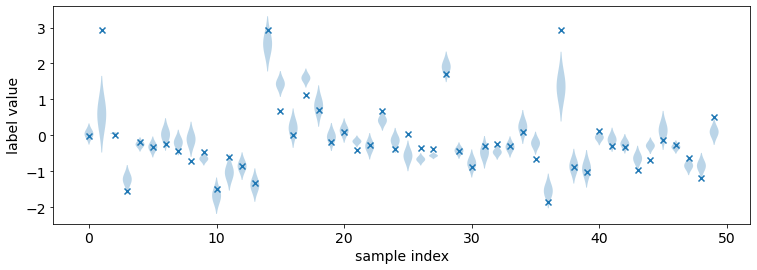

In [5]:
from torchuq.metric import distribution     # All distribution prediction metrics and visualizations are included in the torchuq.metric.point sub-package. 
# Pass in the optional argument "labels" to plot the true labels in the same diagram
# max_count is the maximum number of distributions to plot. Set a reasonable number (such as 50-100) to avoid cluttering the visualization. 
distribution.plot_density(predictions_distribution, labels, max_count=50)  

**CDF Visualization** We can also visualize the CDF functions directly. This is particularly useful when density visualzation fails. For example, not all distributions have a density because the CDF could be dis-continnuous. In torchuq, visualizing the CDF is accomplished by the ``distribution.plot_cdf`` function. 

<AxesSubplot:xlabel='sample index', ylabel='CDF'>

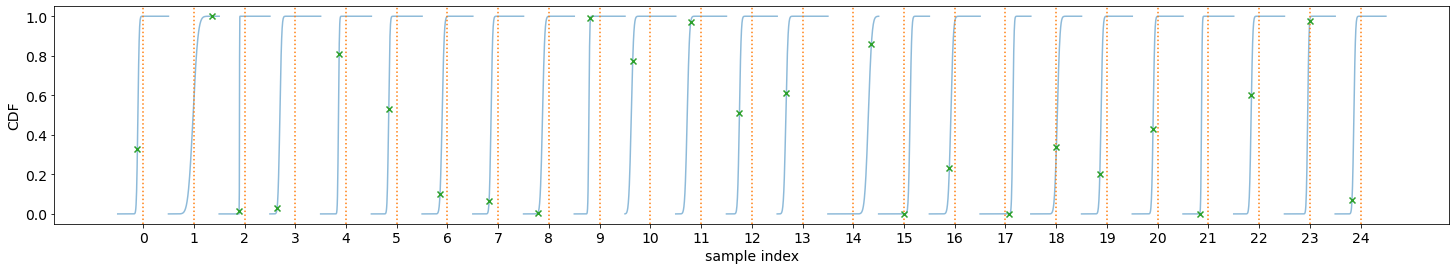

In [10]:
distribution.plot_cdf_sequence(predictions_distribution, labels, max_count=25)

For more available visualizations please refer to [TBD] 

**Scoring Rules**
To evaluate the quality of distribution predictions, we can use proper scoring rules. Let $F^*$ be the true CDF of $Y$, a proper scoring rule is any function that takes small (expected) value when the predicted CDF $F$ is close to the true CDF $F^*$, and large values otherwise. Formally a proper scoring function is a map $s: F, y \mapsto s(F, y) \in \mathbb{R}$ that satisfies 
$$ \mathbb{E}[s(F^*, Y)] \leq \mathbb{E}[s(F, Y)], \forall \text{ CDF } F$$
In other words, no CDF can achieve a smaller score than the true CDF $F^*$ (in expectation). 

There are many common proper scoring rules. Two commonly used scoring rules are 

1. the negative log likelihood (NLL), defined by $s_{\mathrm{NLL}}(F, y) = -\log F'(y)$. Log likelihood is only defined when $F$ is differentiable (i.e. has a density function).  
2. the continuous ranked probability score (CRPS), defined by $s_{\mathrm{CRPS}}(F, y) = \int (F(x) - \mathbb{I}(x \geq y))^2 dx$. Unlike NLL, CRPS is defined even when F is not differentiable. 

In torchuq, the different scoring rules are implemented by functions such as ``distribution.compute_crps`` or ``distribution.compute_nll``. If the score is not defined then these functions will return nan. 

In [12]:
crps = distribution.compute_crps(predictions_distribution, labels).mean()
nll = distribution.compute_nll(predictions_distribution, labels).mean()
print("CRPS score is %.4f, nll score is %.4f " % (crps, nll))

CRPS score is 0.2276, nll score is 2.5124 


The following code demonstrates the fact that CRPS/NLL are proper scoring rules. If we try to predict a less accurate distribution (for example by intentionally shifting the predicted distribution), then the CRPS/NLL score will increase. 

In [14]:
# Try computing the crps for a worse predictive distribution 
import copy
bad_prediction = copy.deepcopy(predictions_distribution)
bad_prediction.loc += 0.5
crps = distribution.compute_crps(bad_prediction, labels).mean()
nll = distribution.compute_nll(bad_prediction, labels).mean()
print("CRPS score is %.4f, nll score is %.4f " % (crps, nll))

CRPS score is 0.4767, nll score is 18.2165 


Other scoring rules are available, to obtain a list of all supported scoring rules call the ``compute_all_scores`` function. For more details of the available scoring rules and other metrics see [TBD] 

In [ ]:
print(distribution.compute_all_scores(predictions_distribution, labels))

**Reliability Diagram and Calibration** 
An important property for distribution prediction is (probabilistic) calibration [3, 4]. Intuitively, 90% of the labels should be below the predicted 90% quantile. 

Probabilitic calibration is only one of many calibration properties for distribution prediction. For additional calibration notions see [TBD]. 

<AxesSubplot:xlabel='quantiles', ylabel='proportion samples below quantile'>

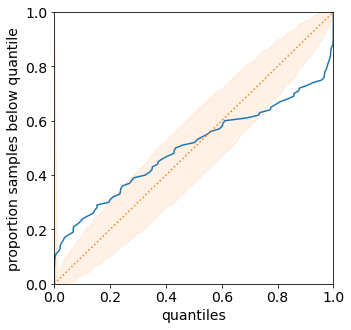

In [15]:
distribution.plot_reliability_diagram(predictions_distribution, labels)

## 3. Quantile Predictions

Need to talk about what are good predictions

In [ ]:
predictions_quantile = reader['predictions_quantile']
from torchuq.metric import quantile 

In [ ]:
quantile.plot_quantiles(predictions_quantile, labels)

In [ ]:
quantile.plot_quantile_calibration(predictions_quantile, labels)

In [ ]:
# Interval predictions
from torchuq.metric import interval
predictions_interval = reader['predictions_interval']
interval.plot_intervals(predictions_interval, labels)

# Part II: Classification

Prediction data types supported for classification 

| Name          |  Variable type/shape  |  Constraint | 
| -----------   |  --------------       |   -------- | 
| Point         | `array [batch_size] with int dtype` |  `Each element take values in {0, 1, ..., num_classes}` |                     
| Categorical   | `array [batch_size, num_classes] with float32 dtype` |  |
| Set           | `array [batch_size, num_classes] with int dtype` |   `Elements are 0 or 1`   |
| Ensemble      | `dict: name -> prediction`  | |


### Probability Prediction 

In [ ]:
from torchuq.metric import categorical

In [ ]:
def plot_calibration_bin(predictions, labels, num_bins=15):
    """ Plot the calibration diagram with binning 
    """
    with torch.no_grad():
        ranking = torch.argsort(predictions.max(dim=1)[0])
        correct = (predictions.argmax(dim=1) == labels.to(predictions.device)).type(torch.float32)
        sorted_confidence = predictions.max(dim=1)[0][ranking]
        sorted_correct = correct[ranking]
        bin_elem = len(predictions) // num_bins
        confidences = []
        accuracy = []
        for i in range(num_bins):
            confidences.append(sorted_confidence[i*bin_elem:(i+1)*bin_elem].mean().cpu().item())
            accuracy.append(sorted_correct[i*bin_elem:(i+1)*bin_elem].mean().cpu().item())
        confidence_boundary = sorted_confidence[::bin_elem].cpu()
        confidences = np.array(confidences)
        plt.bar(x=confidence_boundary[:-1], height=accuracy, 
                width=confidence_boundary[1:] - confidence_boundary[:-1], alpha=0.5, align='edge')
        for i in range(num_bins):
            plt.plot([confidences[i], confidences[i]], [0, accuracy[i]], c='b')
        plt.plot([0,1], [0,1], c='g')
        
plot_calibration_bin

# Reference Table for All Data Types

In this setup, we consider the case where we make a prediction about some random variable $Y$. We will focus on two setups: regression where $Y$ takes values in $\mathbb{R}$ (e.g. $Y$ could represent tomorrow's temperature in your city); and classification where $Y$ takes values in some discrete set $\mathcal{Y}$ (e.g. $Y$ could represent the object category of an image).



# References

[1] Gneiting, Tilmann. "Making and evaluating point forecasts." Journal of the American Statistical Association 106, no. 494 (2011): 746-762.
